In order for this Notebook to work correctly, the virtual memomry Windows 10 machine the Notebook is beign run must be increased. This is beacuse the notebook will download and process sattelite images that genneraly very large. In order to achive this, ther are some system modifications that need to be done before running the Notebook. To increase the virtual memory of the machine: Go to Control panel---> System---> Advanced System Settings. In the window that appears select the Advance tab then settings, in the new window select the advanced tab , the clicl on change. Here untick the "Automatically manage paging file for all drives" Select the Custom size and in the intial size (MB) box enter 4096 and in the Maximumsize (MB) box enter 7000 or 8000. (The maximum size can be increased if the mosai to be created is very large).

In [1]:
#Importing the neccesary libraries for downloading data 
import requests
import time
from datetime import datetime
import pandas as pd
from pathlib import Path
import xmltodict
from zipfile import ZipFile

The following cell will create a folder, where the notebook is located, and all
the downloaded images will be stored there 

In [2]:
# get input for "test name" eg 'PRD_STANDARDISED_TEST_WPS_S1x10_RUN1'
RUNNAME = input()

Test


In [3]:
output_fmt='%Y%m%dT%H%M%S'
pretty_fmt='%Y-%m-%d %H:%M:%S'
headers = {'Content-type': 'application/xml','User-Agent': 'curl/7.65.1'}

wps_test_config = {
        'ras:CropCoverage':{
            'template_xml':'rasterclip-template.xml',
            'mimetype':'image/tiff',
            'output':'result.tiff',
        },
        'gs:Download':{
            'template_xml':'gsdownload-template.xml',
            'mimetype':'application/zip',
            'output':'result.zip',
        },
        'reproject':{
            'template_xml':'reproject_template.xml',
            'mimetype':'application/zip',
            'output':'result.zip',
        },
        'bandselect':{
            'template_xml':'reproject_template.xml',
            'mimetype':'application/zip',
            'output':'result.zip',
        }}

In [4]:
# Load list of granules from dowloaded csv 
#(Those are the resulting csv from eods-api-example-generate-cloudless-mosaic Notebook)
col_list = ["typename"]
min_cloud_per_granule = pd.read_csv(r"C:\Users\Kostas.Sideris\data\min_cloud_per_granule.csv")

min_cloud_per_granule_per_orbit = pd.read_csv(r"C:\Users\Kostas.Sideris\data\min-cloud-per-granule-per-orbit.csv")

In [5]:
### USER INPUT
### Enter your token in PRD_DM = 

wps_job_request_list = [
     {'tool':'gs:Download','layer_list':min_cloud_per_granule_per_orbit["typename"],'dl_bool':True}
]

PRD_DM = "3FKZcj7oGza5DiZ7KBUCVbhMMYLDTl"
ACCESS_TOKEN = PRD_DM

ENV_PRD = 'https://earthobs.defra.gov.uk'
wps_env = ENV_PRD

wps_server = wps_env + '/geoserver/ows/?access_token=' + ACCESS_TOKEN + '&SERVICE=WPS&VERSION=1.0.0'

In [6]:
# submitting the WPS request(s)

def mod_the_xml(xml_name,layer_name):
    """
    function read xml payload template and modify the payload with the config
    """
    
    with open(Path.cwd() / 'xml' / xml_name,'r') as template_xml:
        file_data = template_xml.read()
    modded_xml = file_data.replace('template_layer_name', layer_name)
    
    return modded_xml

def submit_wps_request(payload):
    """
    function submit the wps POST request
    """

    try:
        wps_submit_response = requests.post(wps_server + '&REQUEST=EXECUTE', data=payload, headers=headers, verify=True)
        print('\n' + datetime.utcnow().isoformat() + ' :: request POST url =' + wps_server + '&REQUEST=EXECUTE')
    except:
        print('wps POST was not successful')
    
    # receive status code
    timestamp_submission = datetime.utcnow()
    status_code = wps_submit_response.status_code
        
    if status_code == 200 and not wps_submit_response.text.find('ExceptionReport') > 0:
        execution_id = wps_submit_response.text.split('executionId=')[1].split('&')[0]        
        print('\n' + datetime.utcnow().isoformat() + ':: WPS job ' + execution_id + ' was successfully submitted')
        print('\n' + datetime.utcnow().isoformat() + ':: ' + str(wps_submit_response.content))
        return execution_id
    else:
        print(datetime.utcnow().isoformat() + ' :: wps request was not successful :: STATUS = ' + str(status_code))
        print(datetime.utcnow().isoformat() + ' :: response = ' + str(wps_submit_response.content))
        return None

execution_id_dict={}

for item in wps_job_request_list:
        
    for lyr in item['layer_list']:
        print('\n' + datetime.utcnow().isoformat() + ' :: tool=' + item['tool'] + ', lyr=' + lyr + ', download=' + str(item['dl_bool']))
        modded_xml = mod_the_xml(wps_test_config[item['tool']]['template_xml'],lyr)
        execution_id = submit_wps_request(modded_xml)
        execution_id_dict.update({execution_id:lyr})
        submission_time = datetime.utcnow()

print('\n' + datetime.utcnow().isoformat() + ' :: A TOTAL OF ' + str(len(execution_id_dict)) +  ' WPS REQUESTS SUBMITTED')

print('\n' + datetime.utcnow().isoformat() + ' :: The ExecutionIDs are :: ' + str(execution_id_dict.keys()))

print('\n' + datetime.utcnow().isoformat() + ' :: WPS Check Executions URL is ' + wps_server + '&REQUEST=GetExecutions')


2020-08-28T07:56:33.510200 :: tool=gs:Download, lyr=geonode:S2A_20190224_lat52lon075_T30UXC_ORB037_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref, download=True

2020-08-28T07:56:35.389238 :: request POST url =https://earthobs.defra.gov.uk/geoserver/ows/?access_token=3FKZcj7oGza5DiZ7KBUCVbhMMYLDTl&SERVICE=WPS&VERSION=1.0.0&REQUEST=EXECUTE

2020-08-28T07:56:35.390240:: WPS job baea5b22-2334-4b50-b6c5-c9981643c587 was successfully submitted

2020-08-28T07:56:35.390240:: b'<?xml version="1.0" encoding="UTF-8"?><wps:ExecuteResponse xmlns:xs="http://www.w3.org/2001/XMLSchema" xmlns:ows="http://www.opengis.net/ows/1.1" xmlns:wps="http://www.opengis.net/wps/1.0.0" xmlns:xlink="http://www.w3.org/1999/xlink" xml:lang="en" service="WPS" serviceInstance="https://earthobs.defra.gov.uk/geoserver/ows?access_token=3FKZcj7oGza5DiZ7KBUCVbhMMYLDTl&amp;" statusLocation="https://earthobs.defra.gov.uk/geoserver/ows?service=WPS&amp;version=1.0.0&amp;request=GetExecutionStatus&amp;executionId=baea5b22-2334-4b50

In [7]:
# poll the status page and wait until all jobs are completed

# create output directory and log file
Path(Path.cwd() / 'output').mkdir(parents=True, exist_ok=True)
my_path = Path.cwd() / 'output' / str(submission_time.strftime(output_fmt) + '-' + RUNNAME)
my_path.mkdir(parents=True, exist_ok=True)
log_file_name = my_path / str(submission_time.strftime(output_fmt) + '-' + RUNNAME + '-wps-log.csv')
poll_frequency_sec = 60
frames = []

# poll api for 1 hour unless all jobs submitted are NOT STATUS=RUNNING
for i in range(1,3600):
    
    check_time = datetime.utcnow()
    if i == 1:
        print('\n#' + format(i, '03') + ' of #n   :: ' + submission_time.isoformat() + ' :: Logging file: ' + str(log_file_name))
    
    print('\n#' + format(i, '03') + ' of #n   :: ' + check_time.isoformat() + ' :: Poll Time')
    
    start_index = 0
    matching_of_dicts = []
    for page_counter in range(0,1000,10):

        # constrcut the paging URL and make the request
        all_status_url = wps_server + '&REQUEST=GetExecutions&startIndex=' + str(page_counter)

        r = requests.get(all_status_url,headers=headers)

        # parse the xml to an ordered dict using 3rd party imported module xmltodict
        d = xmltodict.parse(r.content)

        # grab the dicts of 'wps:ExecuteResponse' and add to a list
        jobs_list = [value for value in d['wps:GetExecutionsResponse']['wps:ExecuteResponse']]

        # add this to a master list
        matching_of_dicts.append(jobs_list)

        # if there is no 'next' attribute, then you're on the last xml page so break out the loop
        if not any('@next' == key for key in list(d['wps:GetExecutionsResponse'].keys())):
            break

    num_of_xml_pages = int(page_counter / 10) + 1
    duration_to_parse_xml_dt = datetime.utcnow() - check_time
    duration_to_parse_xml_sec = round(duration_to_parse_xml_dt.total_seconds(),0)
    print('#' + format(i, '03') + ' of #n   :: ' + datetime.utcnow().isoformat() + ' :: ' + str(num_of_xml_pages) + ' xml pages parsed in ' + str(duration_to_parse_xml_sec) + ' seconds')
            
    # now flatten the list into all responses
    response_list = [item['wps:Status'] for sublist in matching_of_dicts for item in sublist]

    # parse dict to pandas dataframe and set the index
    df_temp = pd.DataFrame.from_dict(response_list)
    df = df_temp.set_index('wps:JobID')

    # filter df on current job_ids
    filter_df  = df[df.index.isin(execution_id_dict.keys())]
            
    # add "check time" as column
    filter_df.loc[:,'check_time'] = check_time.isoformat()
    
    # append on some extra info to the dataframe using the index
    for index, row in filter_df.iterrows():
        filter_df.loc[index,'layer_name'] = execution_id_dict[index]
        filter_df.loc[index,'dl_url'] = wps_server + '&REQUEST=GetExecutionResult&EXECUTIONID='  + index + '&outputId=' + wps_test_config['gs:Download']['output'] + '&mimetype=' + wps_test_config['gs:Download']['mimetype']
    
    # sort out the indices and concatenate dataframes together and output to csv
    filter_df.reset_index(inplace=True)
    filter_df.set_index(['wps:JobID','check_time'],inplace=True)
    frames.append(filter_df)
    rolling_merged_df = pd.concat(frames)
    rolling_merged_df.to_csv(log_file_name)
        
    # if NO running processes, then break, otherwise loop again
    if not any(filter_df['wps:Status'] == 'RUNNING'):
        break
    print('#' + format(i, '03') + ' of #n   :: ' + datetime.utcnow().isoformat() + ' :: Jobs are still "STATUS=RUNNING"...script will poll again in ' + str(poll_frequency_sec) + 'sec time ...')
    
    time.sleep(poll_frequency_sec)
    
print('\n#' + format(i, '03') + ' of #' + format(i, '03') + ' :: ' + datetime.utcnow().isoformat() + ' :: Script has finished')


#001 of #n   :: 2020-08-28T07:56:39.445302 :: Logging file: C:\Users\Kostas.Sideris\output\20200828T075639-Test\20200828T075639-Test-wps-log.csv

#001 of #n   :: 2020-08-28T07:57:05.038748 :: Poll Time
#001 of #n   :: 2020-08-28T07:57:13.860898 :: 8 xml pages parsed in 9.0 seconds
#001 of #n   :: 2020-08-28T07:57:13.962903 :: Jobs are still "STATUS=RUNNING"...script will poll again in 60sec time ...


C:\Users\Kostas.Sideris\AppData\Local\Continuum\anaconda3\envs\rsgislibenv\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Kostas.Sideris\AppData\Local\Continuum\anaconda3\envs\rsgislibenv\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s



#002 of #n   :: 2020-08-28T07:58:14.001961 :: Poll Time
#002 of #n   :: 2020-08-28T07:58:22.401107 :: 8 xml pages parsed in 8.0 seconds
#002 of #n   :: 2020-08-28T07:58:22.489109 :: Jobs are still "STATUS=RUNNING"...script will poll again in 60sec time ...

#003 of #n   :: 2020-08-28T07:59:22.490193 :: Poll Time
#003 of #n   :: 2020-08-28T07:59:30.659322 :: 8 xml pages parsed in 8.0 seconds
#003 of #n   :: 2020-08-28T07:59:30.761324 :: Jobs are still "STATUS=RUNNING"...script will poll again in 60sec time ...

#004 of #n   :: 2020-08-28T08:00:30.763184 :: Poll Time
#004 of #n   :: 2020-08-28T08:00:39.496328 :: 8 xml pages parsed in 9.0 seconds

#004 of #004 :: 2020-08-28T08:00:39.588331 :: Script has finished


C:\Users\Kostas.Sideris\AppData\Local\Continuum\anaconda3\envs\rsgislibenv\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-7-73bb5671ecb6>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_df.loc[index,'layer_name'] = execution_id_dict[index]
<ipython-input-7-73bb5671ecb6>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filte

In [8]:
# export summary wps jobs with "runtimes"
sumdf = rolling_merged_df.reset_index()
grouped = sumdf.groupby(['wps:JobID','wps:Status']).first()
grouped.to_csv(my_path / str(submission_time.strftime(output_fmt) + '-' + RUNNAME + '-summary-wps-log.csv'))

In [9]:
# DOWNLOAD, WRITE FILE AND RENAME FILE
for index, row in filter_df.iterrows():
    if row['wps:Status'] == 'SUCCEEDED':
        print('\n\n' + datetime.utcnow().isoformat() + ' :: DOWNLOAD START :: URL = ' + row['dl_url'])        
        response = requests.get(row['dl_url'],headers=headers);
        print(datetime.utcnow().isoformat() + ' :: DOWNLOAD COMPLETE')
        local_file_name = my_path / str(row['layer_name'].split(':')[-1] + '.zip')
        print(datetime.utcnow().isoformat() + ' :: FILE WRITE START :: FILE = ' + str(local_file_name))        
        with open(local_file_name, 'wb') as f:
            f.write(response.content);
            f.close();        
        print(datetime.utcnow().isoformat() + ' :: FILE WRITE COMPLETE')
        print(datetime.utcnow().isoformat() + ' :: EXTRACT ARCHIVE FILE STARTED')
                
        # TODO. Check if downloaded file is actually a zip file type. Handle exception for an xml error report?
        zip_ref = ZipFile(local_file_name, 'r')
        zip_ref.extractall(my_path)
        zip_ref.close()
        print(datetime.utcnow().isoformat() + ' :: EXTRACT ARCHIVE FILE COMPLETE')
        print(datetime.utcnow().isoformat() + ' :: RENAME/CLEAN UP DIRECTORY STARTED')
        for f in zip_ref.filelist:
            if f.filename.endswith(".sld"):
                Path(my_path / f.filename).unlink()
            
            # rename the uuid.tiff to layer_name.tif
            elif f.filename.endswith(".tif") or f.filename.endswith(".tiff"):
                Path(my_path / f.filename).rename(my_path / str(row['layer_name'].split(':')[-1] + '.tif'))
            else:
                raise ValueError("ERROR - some unknown file has been given:", f)
        
        # remove the zip file from disk
        Path(local_file_name).unlink()
        print(datetime.utcnow().isoformat() + ' :: RENAME/CLEAN UP DIRECTORY COMPLETE')

print('\n\n' + datetime.utcnow().isoformat() + ' :: #### SCRIPT FINISHED')



2020-08-28T08:01:46.871543 :: DOWNLOAD START :: URL = https://earthobs.defra.gov.uk/geoserver/ows/?access_token=3FKZcj7oGza5DiZ7KBUCVbhMMYLDTl&SERVICE=WPS&VERSION=1.0.0&REQUEST=GetExecutionResult&EXECUTIONID=c81cb0aa-9897-430d-a6d7-95deaaf81838&outputId=result.zip&mimetype=application/zip
2020-08-28T08:02:41.764535 :: DOWNLOAD COMPLETE
2020-08-28T08:02:41.765535 :: FILE WRITE START :: FILE = C:\Users\Kostas.Sideris\output\20200828T075639-Test\S2A_20190422_lat52lon07_T30UYC_ORB137_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.zip
2020-08-28T08:03:47.435731 :: FILE WRITE COMPLETE
2020-08-28T08:03:47.436725 :: EXTRACT ARCHIVE FILE STARTED
2020-08-28T08:04:29.970504 :: EXTRACT ARCHIVE FILE COMPLETE
2020-08-28T08:04:29.973504 :: RENAME/CLEAN UP DIRECTORY STARTED
2020-08-28T08:04:30.780517 :: RENAME/CLEAN UP DIRECTORY COMPLETE


2020-08-28T08:04:30.781518 :: DOWNLOAD START :: URL = https://earthobs.defra.gov.uk/geoserver/ows/?access_token=3FKZcj7oGza5DiZ7KBUCVbhMMYLDTl&SERVICE=WPS&VERSION=1.0

In [10]:
#Importing libraries for Mosaic creation
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import rsgislib
from rsgislib import imageutils
import glob
import os
import os.path
import sys

In [11]:
#Setting up the folder and the tif files for the mosaic
dirpath= my_path
search_critiria = "*.tif"
q = os.path.join(dirpath,search_critiria)
S2_fps = glob.glob(q)

In [12]:
##Importing libraries for converting .tif to .kea for the Mosaic creation
import os.path
import sys

In [13]:
#Setting up the convertion 
def replaceGTIFF_kea(inputtext):
    outputtext = ""    
    for w in inputtext:
        w = w.replace("GEOTIFF","KEA")
        w = w.replace(".TIF",".kea")
        # this line should be unnecessary since Landsat MTL files use capital letters       
        # but just in case you have one that doesn't
        w = w.replace(".tif",".kea")
        outputtext += w
    return outputtex

In [14]:
# find all *.TIF files and *MTL.txt files in the current directory
directory = os.chdir(my_path)
dirFileList = os.listdir(directory)

In [15]:
# print dirFileList
tifFileList = [f for f in dirFileList if ((f[-4:]=='.TIF')or(f[-4:]=='.tif'))]
MTLFileList = [f for f in dirFileList if (f[-7:]=='MTL.txt')]

In [16]:
#output format (GDAL code)
outFormat = 'KEA'

In [17]:
# run gdal_translate on all TIFs to convert to KEA
for t in tifFileList:
    gdaltranscmd = "gdal_translate -of "+outFormat+" "+t+" "+t[:-4]+".kea"
    print (gdaltranscmd)
    os.system(gdaltranscmd)

gdal_translate -of KEA S2A_20190330_lat52lon075_T30UXC_ORB094_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.tif S2A_20190330_lat52lon075_T30UXC_ORB094_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.kea
gdal_translate -of KEA S2A_20190330_lat52lon07_T30UYC_ORB094_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.tif S2A_20190330_lat52lon07_T30UYC_ORB094_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.kea
gdal_translate -of KEA S2A_20190422_lat52lon07_T30UYC_ORB137_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.tif S2A_20190422_lat52lon07_T30UYC_ORB137_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.kea


In [18]:
# create a new header file referring to .kea files rather than .TIF
for m in MTLFileList:
    inputtext = file(m).readlines()
    outputtext = replaceGTIFF_kea(inputtext)
    outputfilebase = m[:-4]
    outputfile = outputfilebase + "_kea.txt"
    out = file(outputfile,"w")
    out.write(outputtext)
    out.close()

In [19]:
#Setting up the paths for finding the created .kea files
dirpath= my_path
search_critiria_kea = "*.kea"
q = os.path.join(dirpath,search_critiria_kea)
S2 = glob.glob(q)

In [20]:
S2

['C:\\Users\\Kostas.Sideris\\output\\20200828T075639-Test\\S2A_20190330_lat52lon075_T30UXC_ORB094_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.kea',
 'C:\\Users\\Kostas.Sideris\\output\\20200828T075639-Test\\S2A_20190330_lat52lon07_T30UYC_ORB094_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.kea',
 'C:\\Users\\Kostas.Sideris\\output\\20200828T075639-Test\\S2A_20190422_lat52lon07_T30UYC_ORB137_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.kea']

In [21]:
# Mosaicing all the .kea files 
inputList = S2
outImage = r'C:\Users\Kostas.Sideris\output\Mosaic\mosaic.kea'
backgroundVal = 0.
skipVal = 0.
skipBand = 1
overlapBehaviour = 0
gdalformat = 'KEA'
datatype = rsgislib.TYPE_32FLOAT
imageutils.createImageMosaic(inputList, outImage, backgroundVal, skipVal, skipBand, overlapBehaviour, gdalformat, datatype)

In [22]:
#Converting the created .kea mosaic back to .tif 
def replaceGTIFF_kea(inputtext):
    outputtext = ""    
    for w in inputtext:
        w = w.replace("KEA","GEOTIFF")
        w = w.replace(".kea",".TIF")
        # this line should be unnecessary since Landsat MTL files use capital letters       
        # but just in case you have one that doesn't
        w = w.replace(".kea",".tif")
        outputtext += w
    return outputtex

In [23]:
# find all *.kea files and *MTL.txt files in the current directory
directory = os.chdir("C:/Users/Kostas.Sideris/output/Mosaic")
dirFileList = os.listdir(directory)

In [24]:
# print dirFileList
tifFileList = [f for f in dirFileList if ((f[-4:]=='.KEA')or(f[-4:]=='.kea'))]
MTLFileList = [f for f in dirFileList if (f[-7:]=='MTL.txt')]

In [25]:
#output format (GDAL code)
outFormat = 'GTiff'

In [26]:
#run gdal_translate on the .KEA Mosaic  to convert to .tiff
for t in tifFileList:
    gdaltranscmd = "gdal_translate -of "+outFormat+" "+t+" "+t[:-4]+".tif"
    print (gdaltranscmd)
    os.system(gdaltranscmd)

gdal_translate -of GTiff mosaic.kea mosaic.tif


In [27]:
#Importing libraries for clipping 
import fiona
import rasterio 
import rasterio.mask
#Importing the shapefile that will be used for clipping
with fiona.open(r"C:\Users\Kostas.Sideris\output\Mosaic\clipper2.shp") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]



In [28]:
#Clipping the Mosaic with the shapefile
with rasterio.open(r"C:\Users\Kostas.Sideris\output\Mosaic\Mosaic.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

In [29]:
#Saving the created cliped raster
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(r"C:\Users\Kostas.Sideris\output\Mosaic\County.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [30]:
#Importing libraires for NDVI
import numpy as np
from rasterio.plot import show
import earthpy.spatial as es

In [32]:
#Importing the clipped Mosaic
naip_data_path = r"C:\Users\Kostas.Sideris\output\Mosaic\County.tif"

with rasterio.open(naip_data_path) as src:
    naip_data = src.read()

# View shape of the data
naip_data.shape

(10, 6549, 8990)

In [33]:
#Calculate the NDVI for the clipped Mosaic. 
naip_ndvi = es.normalized_diff(naip_data[3], naip_data[8])

C:\Users\Kostas.Sideris\AppData\Local\Continuum\anaconda3\envs\rsgislibenv\lib\site-packages\earthpy\spatial.py:105: RuntimeWarning: invalid value encountered in true_divide
  n_diff = (b1 - b2) / (b1 + b2)


In [34]:
#Importing libraries for plotting the results.
import earthpy.plot as ep
import matplotlib.pyplot as plt

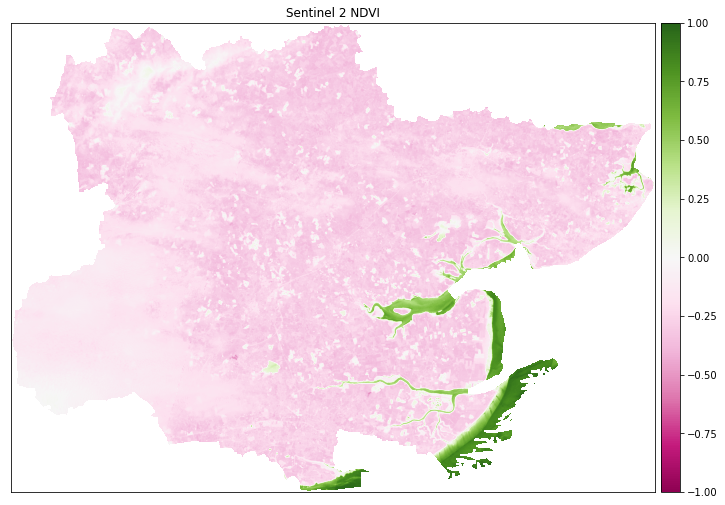

In [35]:
#Ploting the created NDVI
ep.plot_bands(naip_ndvi, 
              cmap='PiYG',
              scale=False,
              vmin=-1, vmax=1,
              title="Sentinel 2 NDVI")
plt.show()



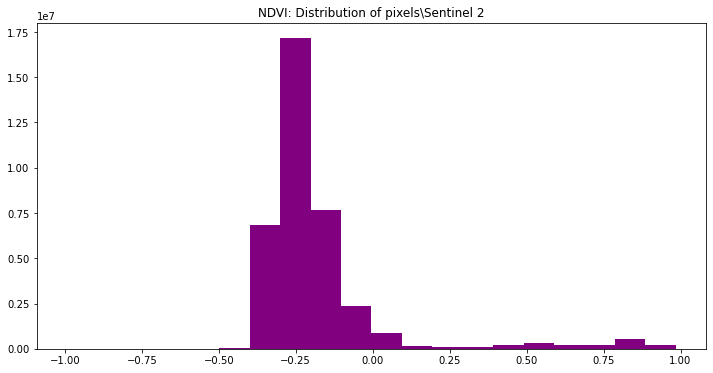

In [36]:
#Creating a histogram showing the attribute distribution of the NDVI
ep.hist(naip_ndvi,
        figsize=(12, 6),
        title=["NDVI: Distribution of pixels\Sentinel 2"])

plt.show()

In [37]:
#Viewing the metadata of the NDVI
with rasterio.open(naip_data_path) as src:
    naip_data = src.read()
    naip_meta = src.profile

naip_meta

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 8990, 'height': 6549, 'count': 10, 'crs': CRS.from_epsg(27700), 'transform': Affine(10.0, 0.0, 536930.0,
       0.0, -10.0, 246590.0), 'tiled': False, 'interleave': 'pixel'}

In [38]:
#Saving the CRS for the NDVI
naip_transform = naip_meta["transform"]
naip_crs = naip_meta["crs"]

# View spatial attributes
naip_transform, naip_crs

(Affine(10.0, 0.0, 536930.0,
        0.0, -10.0, 246590.0),
 CRS.from_epsg(27700))

In [39]:
type(naip_ndvi), naip_ndvi.dtype

(numpy.ma.core.MaskedArray, dtype('float32'))

In [40]:
naip_meta


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 8990, 'height': 6549, 'count': 10, 'crs': CRS.from_epsg(27700), 'transform': Affine(10.0, 0.0, 536930.0,
       0.0, -10.0, 246590.0), 'tiled': False, 'interleave': 'pixel'}

In [41]:
# Change the count or number of bands from 4 to 1
naip_meta['count'] = 1

# Change the data type to float rather than integer
naip_meta['dtype'] = "float64"
naip_meta


{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 8990, 'height': 6549, 'count': 1, 'crs': CRS.from_epsg(27700), 'transform': Affine(10.0, 0.0, 536930.0,
       0.0, -10.0, 246590.0), 'tiled': False, 'interleave': 'pixel'}

In [42]:
#Saving the created NDVI raster
naip_ndvi_outpath = r"C:\Users\Kostas.Sideris\output\Mosaic\NDVI.tif"


with rasterio.open(naip_ndvi_outpath, 'w', **naip_meta) as dst:
    dst.write(naip_ndvi, 1)

ValueError: the array's dtype 'float32' does not match the file's dtype 'float64'